Christian Hellum Bye \
chbye@berkeley.edu \
04-25-22

# Homework 9: scikit-image

Due April 28th at 8pm

## Asteroid tracking

Complete the asteroid tracking breakout from class.

What worked well, what went wrong, and what approaches could help in a real-world scenario to improve results?

In [1]:
import skimage as ski
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['figure.figsize'] = (10, 7)

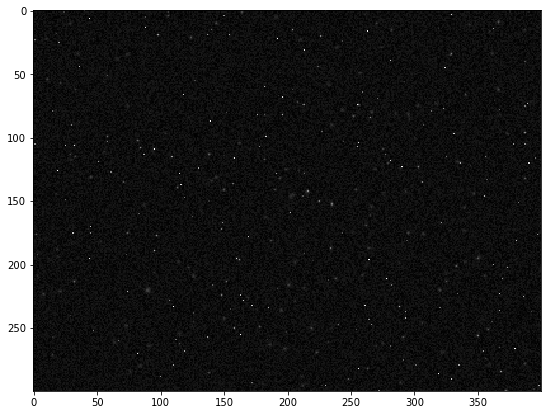

In [15]:
# asteroid images
frames = ski.io.ImageCollection('data/asteroid_*.png')
# show a random image
plt.imshow(frames[3])
plt.show()

In [16]:
# gif of images
from IPython.display import Image
Image('data/asteroid.gif', width=600)

There is a moving object in these frames (a single frame shown above)! Can you find it? We know that the object moves in a straight line; can you fit a line to its trajectory?

# From class

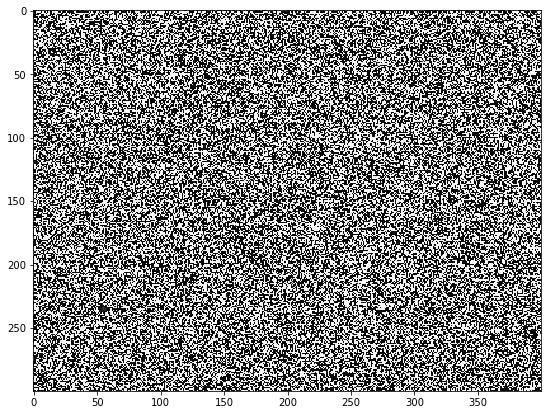

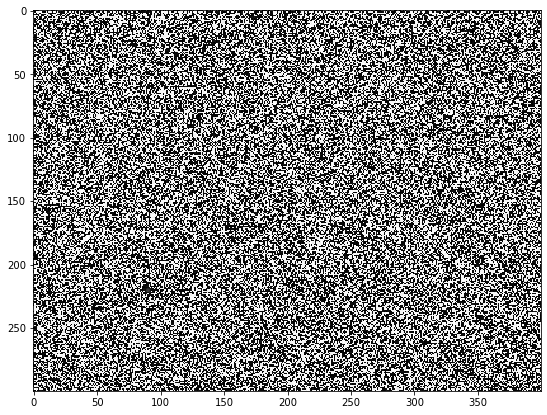

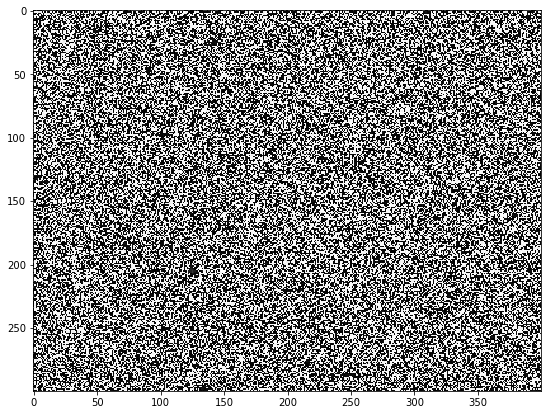

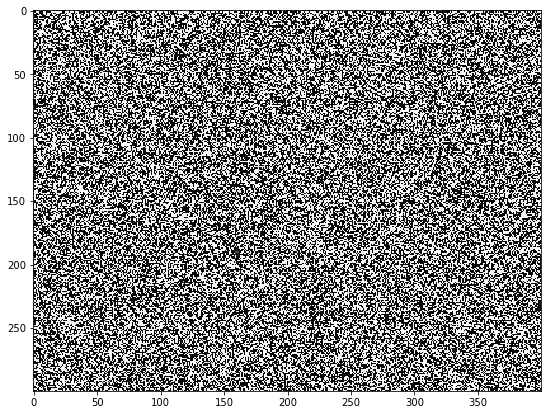

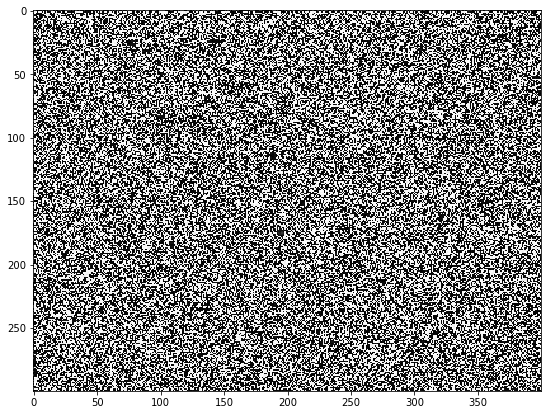

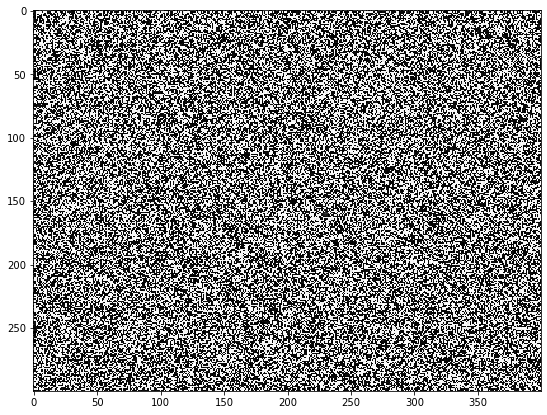

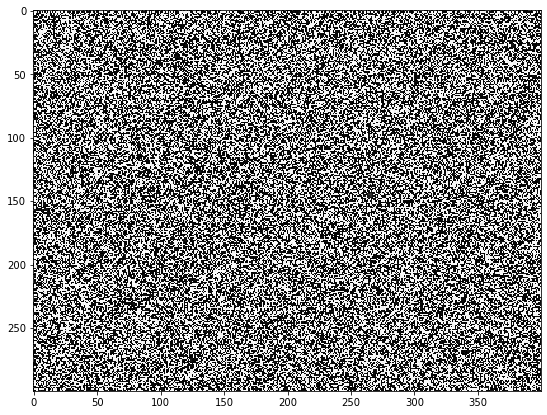

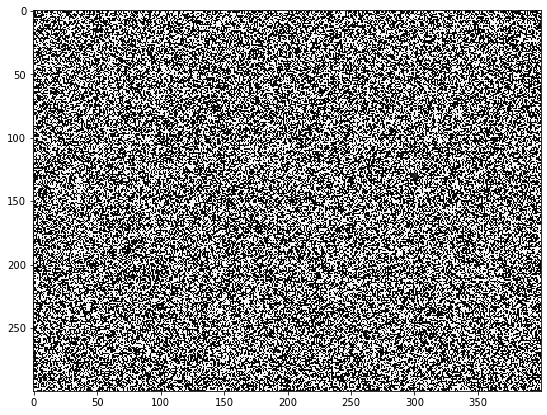

In [18]:
# image 0 is a reference image without the asteroid
# Hence, the asteroid should be in the difference of other frames and the reference frame. The rest is noise.
for i in range(1, len(frames)):
    plt.imshow(frames[i] - frames[0])
    plt.show()

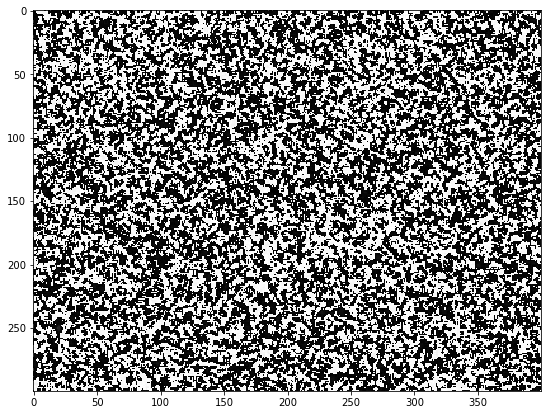

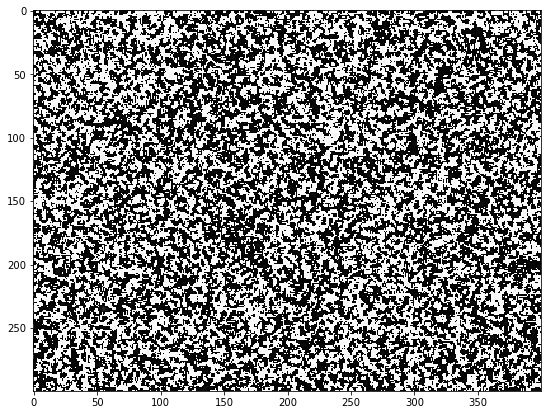

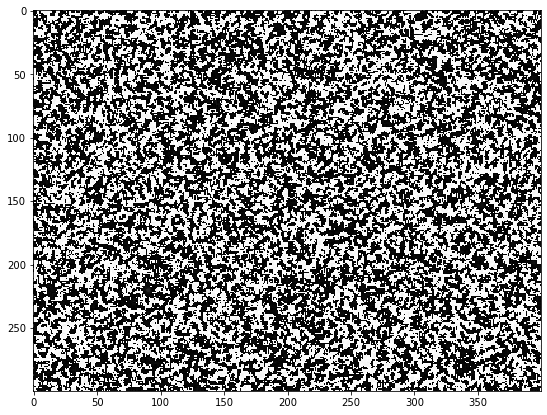

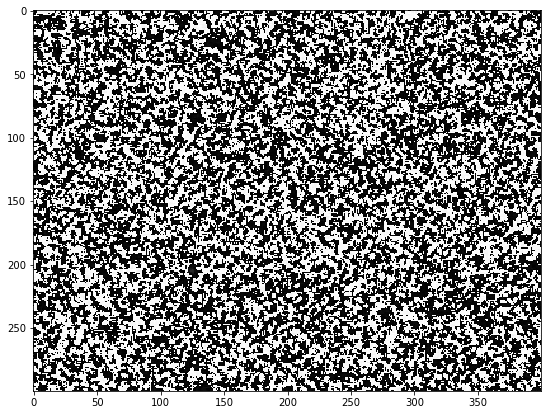

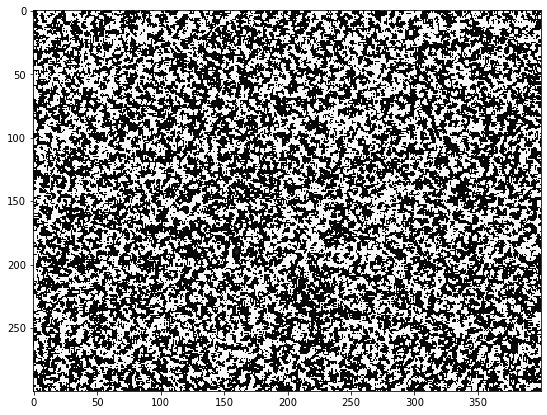

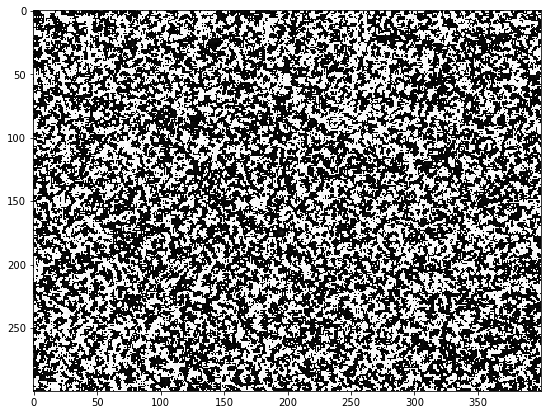

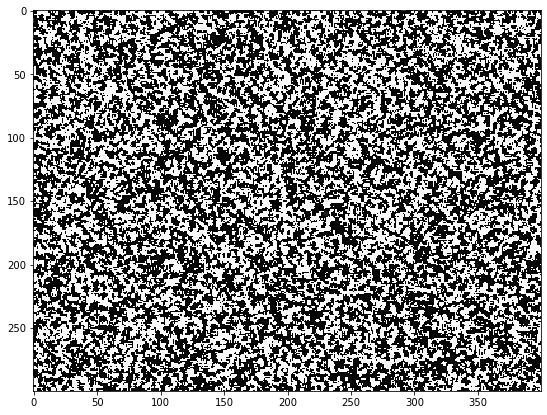

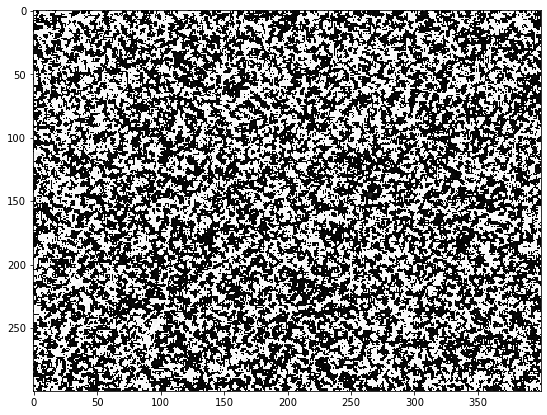

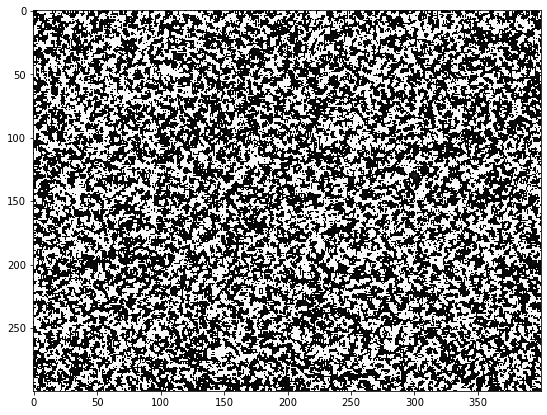

In [19]:
# try denoising with median fiter
denoised = [ski.filters.median(x) for x in frames]
for i in range(1, len(frames)):
    plt.imshow(denoised[i] - denoised[0])
    plt.show()

The images are all noisy still and we cannot see the asteroid when subtracting the reference frame. Try instead subtracting mean of the frames from the denoised image. 

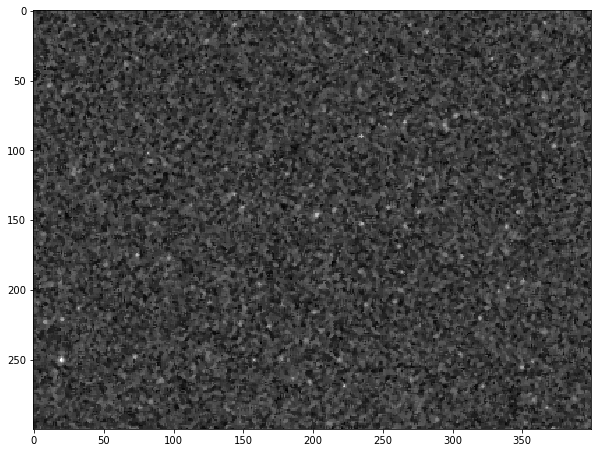

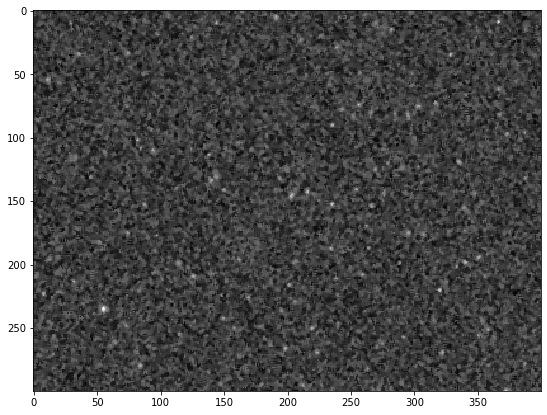

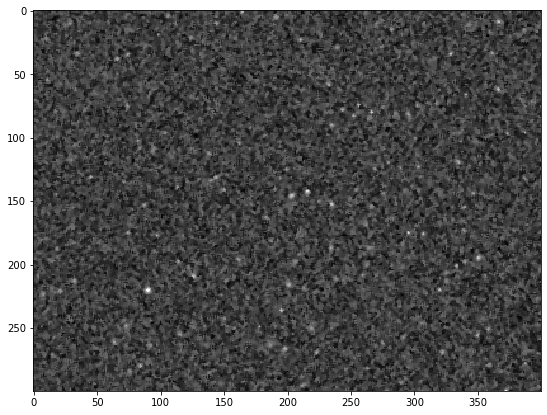

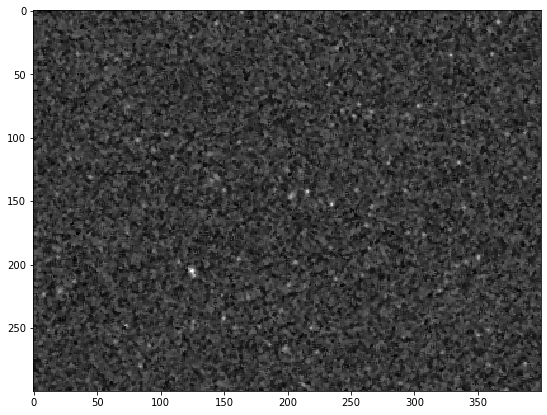

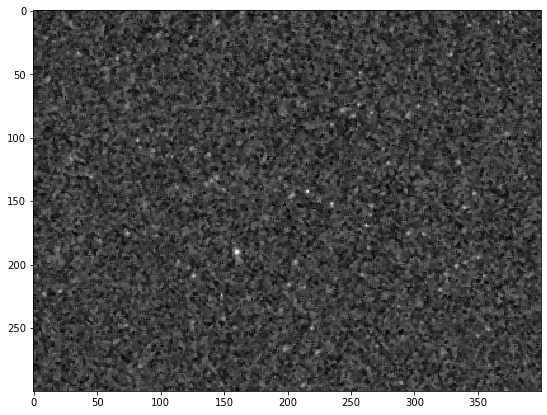

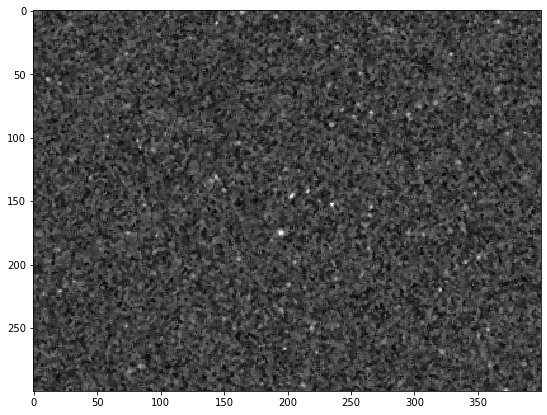

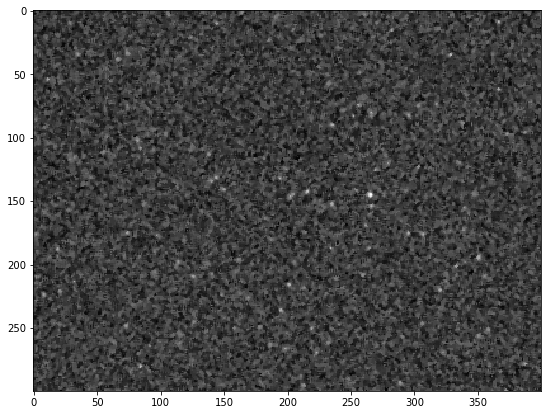

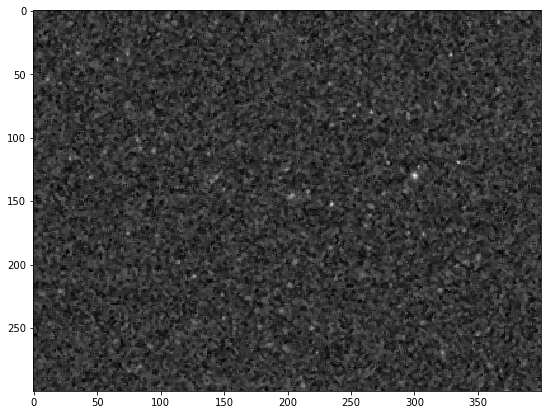

In [20]:
plt.figure(figsize=(10, 10))
for i in range(1, len(frames)):
    plt.imshow(denoised[i] - np.mean(frames))
    plt.show()

The asteroid should be where the difference between the images is the greatest. Let's look at that in the case of the third frame.

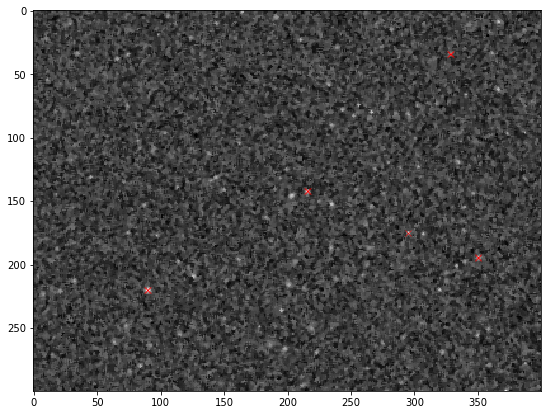

In [21]:
delta = denoised[3] - np.mean(frames)  # difference between frame 3 and mean of frames
T = 0.7  # minimum intensity of local peaks: they need to be at least 70% the brightness of the global max

peaks = ski.feature.peak_local_max(delta, threshold_rel=T)
plt.imshow(delta)
plt.scatter(peaks[:, 1], peaks[:, 0], marker='x', lw=0.5, color='red')  # highlight the local maxs in red
plt.show()

Having localized some candidate peaks in frame 3, we redo the analysis for all frames.

In [27]:
all_peaks = []
mean_frame = np.mean(frames)
for f in denoised[1:]:
    delta = f - mean_frame
    peaks = ski.feature.peak_local_max(delta, threshold_rel=T)
    all_peaks.extend(peaks.tolist())

In [28]:
all_peaks = np.array(all_peaks)
all_peaks.shape = (-1, 2)

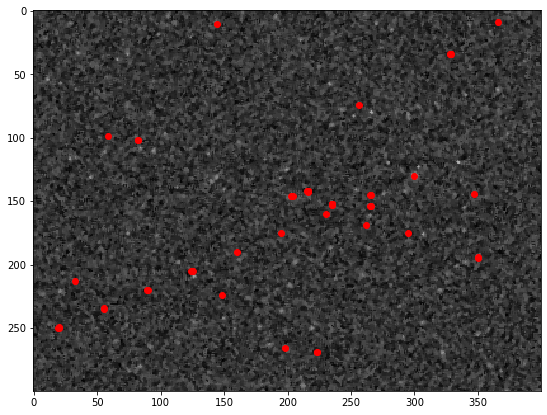

In [29]:
plt.imshow(delta)
plt.scatter(all_peaks[:, 1], all_peaks[:, 0], color='r', marker='o');

In [30]:
# use the RANSAC algorithm to fit a linear model to the peaks
model, inliers = ski.measure.ransac(all_peaks[:, ::-1],
                                    ski.measure.LineModelND,
                                    min_samples=2,
                                    residual_threshold=1)

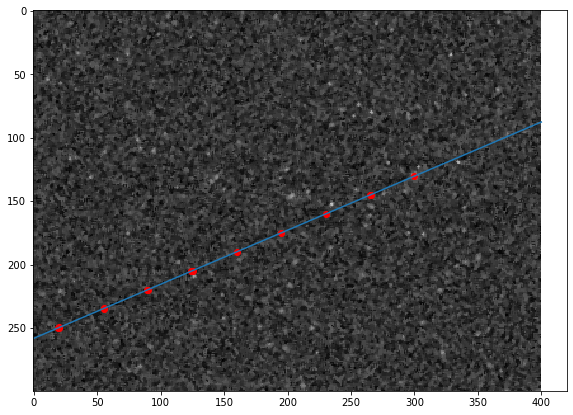

In [31]:
plt.imshow(delta)
track = all_peaks[inliers]
plt.scatter(track[:, 1], track[:, 0], color='r', marker='o')

x = np.linspace(0, delta.shape[1], 100)
plt.plot(x, model.predict_y(x))
plt.show()

The algorithm gives us an origin, $\mathcal{O}$, and direction, $\mathbf{v}$, defined such that any point $\mathbf{X}$ on the line satisfies:
$$\mathbf{X}(t) = \mathcal{O} + t\mathbf{v}$$

This can be rewritten as:
$$
\begin{cases}
    x(t) = \mathcal{O}_x + tv_x \\
    y(t) = \mathcal{O}_y + tv_y
\end{cases}
$$

Thus,

$$t = \frac{x-\mathcal{O}_x}{v_x} \\
y(x) = \mathcal{O}_y + \frac{x-\mathcal{O}_x}{v_x}v_y \\
y(x) = \frac{v_y}{v_x}x + \left(\mathcal{O}_y + \frac{v_y}{v_x}\mathcal{O}_x\right)$$

In [43]:
origin, direction = model.params

slope = direction[1]/direction[0]
intercept = origin[1] + slope*origin[0]

print(f"The line of best fit is given by y={slope:.2g}x+{intercept:.2g}.")

The line of best fit is given by y=-0.43x+1.4e+02.


## Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

## Image Stacking

Stack several photos of the night sky to reveal its structure. Here are some datasets you can use:

- https://chandra.harvard.edu/photo/openFITS/
- https://esahubble.org/projects/fits_liberator/m17data/
- https://www.photographingspace.com/homework-download-stack-data/
- https://www.astropix.com/html/processing/practice_files.html
- https://www.astrobin.com/forum/c/astrophotography/other/all-my-raw-files-are-or-will-be-public-online/

(While you should use Python code to do the stacking, you can also compare your results to those obtained using dedicated software such as https://siril.org/.)